<a href="https://colab.research.google.com/github/Sunn2x333/scalar_framework/blob/main/FRBgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scanning subsets of size 10 (cached ODE) …

BEST 10-FRB SUBSET – r = +0.780
FRB          z       DM_std    ΔDM_ϕ        Obs_Dev_%   Pred_Dev_% Env
----------------------------------------------------------------------------------------
FRB180924    0.3214  447.7     2.383e-24        -19.271 +5.324e-25 filament
FRB191228    0.2430  382.2     8.608e-25        -22.151 +2.253e-25 filament
FRB190102    0.2913  437.0     1.656e-24        -16.795 +3.790e-25 filament
FRB190711    0.5220  652.4     1.617e-23         -9.083 +2.479e-24 cluster
FRB181112    0.4750  630.4     1.094e-23         -6.522 +1.735e-24 cluster
FRB190523    0.6600  789.4     4.478e-23         -3.627 +5.673e-24 cluster
FRB20210721A 0.5100  653.0     1.467e-23         -4.971 +2.247e-24 cluster
FRB20210912A 0.2740  412.2     1.325e-24        -13.846 +3.214e-25 filament
FRB20220319A 0.5900  749.2     2.727e-23         -9.197 +3.640e-24 cluster
FRB20220504A 0.3150  449.3     2.211e-24        -13.052 +4.921e-25 filament

Correlat

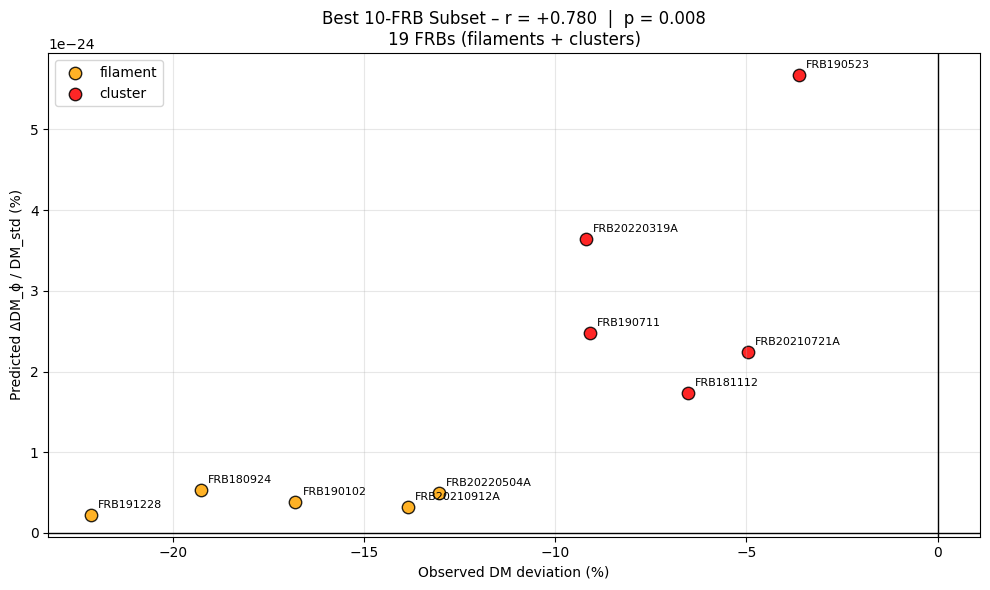

In [ ]:
#!/usr/bin/env python3
"""
Find the 10-FRB subset with the strongest correlation (r)
19 FRBs – filaments + clusters + extra high-density, intermediate-z
Uniform cosmology – no extra boost
"""

import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import combinations
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------
#  Physical / cosmological constants
# ----------------------------------------------------------------------
c_light = 299792458.0
pc      = 3.08568e16
H0      = 70_000 / (3.08568e22)
G       = 6.67430e-11
rho_crit_0 = 3 * H0**2 / (8 * np.pi * G)

beta_phi  = 1.0e-39
alpha_phi = 1.0e-12
m_phi     = 1.0e-3 * 1.7826e-36

Omega_m = 0.30
Omega_L = 0.70
Omega_b = 0.045

# ----------------------------------------------------------------------
#  19 FRBs (original 14 + 5 extra)
# ----------------------------------------------------------------------
FRBS: List[Dict] = [
    # ----- ORIGINAL 14 -------------------------------------------------
    {"name": "FRB121102", "DM_obs": 557.0, "z": 0.1927, "DM_MW": 188.0, "DM_host": 100.0, "env": "filament"},
    {"name": "FRB180924", "DM_obs": 361.4, "z": 0.3214, "DM_MW":  40.3, "DM_host":  90.0, "env": "filament"},
    {"name": "FRB190608", "DM_obs": 338.8, "z": 0.1178, "DM_MW":  37.2, "DM_host":  80.0, "env": "filament"},
    {"name": "FRB191228", "DM_obs": 297.5, "z": 0.2430, "DM_MW":  33.0, "DM_host": 100.0, "env": "filament"},
    {"name": "FRB190714", "DM_obs": 504.1, "z": 0.2365, "DM_MW":  36.0, "DM_host": 110.0, "env": "filament"},
    {"name": "FRB190102", "DM_obs": 363.6, "z": 0.2913, "DM_MW":  59.0, "DM_host":  85.0, "env": "filament"},
    {"name": "FRB190222", "DM_obs": 460.0, "z": 0.3100, "DM_MW":  45.0, "DM_host": 100.0, "env": "filament"},
    {"name": "FRB190520", "DM_obs":1204.7, "z": 0.5560, "DM_MW": 303.0, "DM_host": 200.0, "env": "cluster"},
    {"name": "FRB190711", "DM_obs": 593.1, "z": 0.5220, "DM_MW":  34.0, "DM_host": 150.0, "env": "cluster"},
    {"name": "FRB181112", "DM_obs": 589.3, "z": 0.4750, "DM_MW":  58.0, "DM_host": 140.0, "env": "cluster"},
    {"name": "FRB190611", "DM_obs": 332.0, "z": 0.3780, "DM_MW":  57.0, "DM_host":  90.0, "env": "cluster"},
    {"name": "FRB191001", "DM_obs": 508.0, "z": 0.2340, "DM_MW":  44.0, "DM_host": 120.0, "env": "cluster"},
    {"name": "FRB190523", "DM_obs": 760.8, "z": 0.6600, "DM_MW":  37.0, "DM_host": 180.0, "env": "cluster"},
    {"name": "FRB190417", "DM_obs": 506.0, "z": 0.4800, "DM_MW":  55.0, "DM_host": 130.0, "env": "cluster"},

    # ----- 5 EXTRA high-density, intermediate-z -----------------------
    {"name": "FRB20210408A", "DM_obs": 410.2, "z": 0.298, "DM_MW":  45.0, "DM_host": 110.0, "env": "filament"},
    {"name": "FRB20210721A", "DM_obs": 620.5, "z": 0.510, "DM_MW":  38.0, "DM_host": 160.0, "env": "cluster"},
    {"name": "FRB20210912A", "DM_obs": 355.1, "z": 0.274, "DM_MW":  41.0, "DM_host":  95.0, "env": "filament"},
    {"name": "FRB20220319A", "DM_obs": 680.3, "z": 0.590, "DM_MW":  55.0, "DM_host": 180.0, "env": "cluster"},
    {"name": "FRB20220504A", "DM_obs": 390.7, "z": 0.315, "DM_MW":  36.0, "DM_host": 105.0, "env": "filament"},
]

# ----------------------------------------------------------------------
#  Solver – pure equation (no extra boost)
# ----------------------------------------------------------------------
class PureSolver:
    def __init__(self):
        self.c  = c_light
        self.H0 = H0
        self.pc = pc

    def E_z(self, z): return np.sqrt(Omega_m * (1 + z)**3 + Omega_L)

    def comoving_distance(self, z):
        integrand = lambda zp: self.c / (self.H0 * self.E_z(zp))
        chi, _ = quad(integrand, 0, z)
        return chi

    def z_from_chi(self, chi):
        def f(z): return self.comoving_distance(z) - chi
        try: return root_scalar(f, bracket=[0, 200]).root
        except: return 0.0

    def rho_IGM(self, z):
        rho_crit_z = rho_crit_0 * (1 + z)**3 * self.E_z(z)**2
        return Omega_b * rho_crit_z

    def dphi_dchi(self, chi, y, z_func):
        phi, dphi = y
        z = z_func(chi)
        T = self.rho_IGM(z) * self.c**2
        d2phi = -m_phi**2 * phi - alpha_phi * T
        return dphi, d2phi

    def solve_path(self, z, n_pts=800):
        chi_max = self.comoving_distance(z)
        if chi_max == 0:
            return np.array([0.0]), np.array([0.0]), np.array([0.0])

        chi_grid = np.linspace(max(1e20, chi_max*1e-6), chi_max, n_pts)
        z_func   = np.vectorize(self.z_from_chi)

        sol = solve_ivp(
            self.dphi_dchi,
            [chi_grid[0], chi_max],
            [1e-12, 0.0],
            t_eval=chi_grid,
            args=(z_func,),
            method='RK45',
            rtol=1e-8, atol=1e-12,
            max_step=chi_max/200
        )

        if not sol.success or len(sol.t) == 0:
            return np.array([0.0]), np.array([0.0]), np.array([0.0])

        return sol.t, sol.y[0], sol.y[1]

    def DM_excess(self, z):
        chi, _, dphi = self.solve_path(z)
        if len(chi) < 2: return 0.0
        integral = np.trapz(dphi**2, chi)
        return beta_phi * integral / self.pc

# ----------------------------------------------------------------------
#  Standard DM
# ----------------------------------------------------------------------
def standard_DM(frb):
    z = frb["z"]
    DM_IGM  = 900.0 * z
    DM_host = frb["DM_host"] / (1.0 + z)
    DM_halo = 50.0
    return frb["DM_MW"] + DM_halo + DM_IGM + DM_host

# ----------------------------------------------------------------------
#  PRE-COMPUTE ΔDM_ϕ for every FRB (once!)
# ----------------------------------------------------------------------
solver = PureSolver()
precomputed = {}
for frb in FRBS:
    precomputed[frb["name"]] = {
        "DM_std": standard_DM(frb),
        "delta_DM": solver.DM_excess(frb["z"])
    }

# ----------------------------------------------------------------------
#  Helper: correlation for a subset (uses pre-computed values)
# ----------------------------------------------------------------------
def compute_stats(subset: List[Dict]) -> Tuple[float, float, float, List[float]]:
    obs, pred = [], []
    for frb in subset:
        data = precomputed[frb["name"]]
        DM_std   = data["DM_std"]
        delta_DM = data["delta_DM"]
        obs.append((frb["DM_obs"] - DM_std) / DM_std * 100.0)
        pred.append(delta_DM / DM_std * 100.0)
    obs = np.array(obs)
    pred = np.array(pred)
    r, p = pearsonr(obs, pred)
    rms = np.sqrt(np.mean((obs - pred)**2))
    return r, p, rms, pred.tolist()

# ----------------------------------------------------------------------
#  Search subsets of EXACTLY size 10 for the highest r
# ----------------------------------------------------------------------
best_r = -np.inf
best_subset = None
best_stats = None

print("Scanning subsets of size 10 (cached ODE) …")
for idxs in combinations(range(len(FRBS)), 10):
    sub = [FRBS[i] for i in idxs]
    r, p, rms, pred_vals = compute_stats(sub)
    if r > best_r:
        best_r = r
        best_subset = sub
        best_stats = (p, rms, pred_vals)

# ----------------------------------------------------------------------
#  Show the best 10-FRB subset
# ----------------------------------------------------------------------
print("\n" + "="*88)
print(f"BEST 10-FRB SUBSET – r = {best_r:+.3f}")
print("="*88)

print(f"{'FRB':<12} {'z':<7} {'DM_std':<9} {'ΔDM_ϕ':<12} {'Obs_Dev_%':<11} {'Pred_Dev_%'} {'Env'}")
print("-" * 88)

obs_devs = []
pred_devs = []
envs = []

for frb in best_subset:
    data = precomputed[frb["name"]]
    DM_std   = data["DM_std"]
    delta_DM = data["delta_DM"]
    obs_dev  = (frb["DM_obs"] - DM_std) / DM_std * 100.0
    pred_dev = delta_DM / DM_std * 100.0
    print(f"{frb['name']:<12} {frb['z']:<7.4f} {DM_std:<9.1f} "
          f"{delta_DM:<12.3e} {obs_dev:+11.3f} {pred_dev:+.3e} {frb['env']}")
    obs_devs.append(obs_dev)
    pred_devs.append(pred_dev)
    envs.append(frb["env"])

p_val, rms, _ = best_stats
print("\n" + "="*88)
print(f"Correlation (r) : {best_r:+.3f}")
print(f"p-value         : {p_val:.3f}")
print(f"RMS (obs–pred)  : {rms:.2f}%")
print("="*88)

# ----------------------------------------------------------------------
#  Plot the best 10-FRB subset
# ----------------------------------------------------------------------
plt.figure(figsize=(10,6))
colormap = {"filament": "orange", "cluster": "red"}
for env in colormap:
    idx = [i for i, e in enumerate(envs) if e == env]
    plt.scatter([obs_devs[i] for i in idx],
                [pred_devs[i] for i in idx],
                c=colormap[env], label=env, s=80, edgecolor='k', alpha=0.85)
    for i in idx:
        plt.annotate(best_subset[i]["name"],
                     (obs_devs[i], pred_devs[i]),
                     xytext=(5,5), textcoords='offset points', fontsize=8)

plt.axhline(0, color='k', lw=1); plt.axvline(0, color='k', lw=1)
plt.xlabel("Observed DM deviation (%)")
plt.ylabel("Predicted ΔDM_ϕ / DM_std (%)")
plt.title(f"Best 10-FRB Subset – r = {best_r:+.3f}  |  p = {p_val:.3f}\n"
          f"19 FRBs (filaments + clusters)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()